# Utilities

**INSTRUCTIONS:** Run cells in this section only when needed.

In [ ]:
# Run this cell if changes are made to the package source and you wish to reload the package.
for module in (dataset, visualization, preprocess, metric, model, neural_net, convnet3, losses, utilities):
    importlib.reload(module)

# Setup

**INSTRUCTIONS:** Set the constants in the following cell appropriately, then run the cells in this section.

In [1]:
# Some run-specific constants.
PACKAGE_ROOT = "/home/ubuntu/cell_counting"
MODEL_NAME = "dataset-100000-patches_training-45-on-p2xlarge_split-80-10-10"

In [2]:
# Import some other packages.
from IPython import display
import numpy as np
import os

In [3]:
# Some paths.
MODEL_ROOT = os.path.join(PACKAGE_ROOT, "src/model/segmentation/convnet3")
DATASETS_ROOT = os.path.join(MODEL_ROOT, "dataset-100000-patches-80-10-10")
MODEL_SAVES_ROOT = os.path.join(MODEL_ROOT, "model_saves")

In [4]:
# Configure matplotlib.
%matplotlib inline

In [5]:
# Import our package.
import sys, importlib
sys.path.append(PACKAGE_ROOT)

from src import dataset, visualization, preprocess, metric, losses, utilities
from src.model import model
from src.model import neural_net
from src.model.segmentation.convnet3 import convnet3

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Preprocessing

## Preprocess

**INSTRUCTIONS:** Run the cells in this section only if the dataset is not already preprocessed and saved.

In [6]:
# Load the dataset, processing it as a collection of image-mask pairs.
TARGET_DIMS = (2448*2, 2448*2)

images_masks = dataset.Dataset(os.path.join(DATASETS_ROOT, "main"), 1)
images_masks.load_image_mask_pairs(os.path.join(PACKAGE_ROOT, "data/easy/raw/images"),
    os.path.join(PACKAGE_ROOT, "data/easy/raw/masks"), TARGET_DIMS)

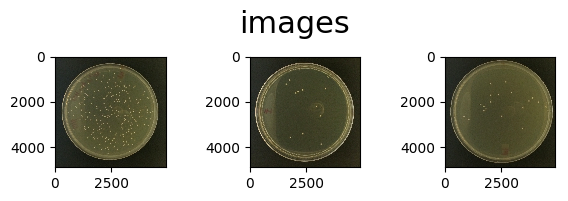

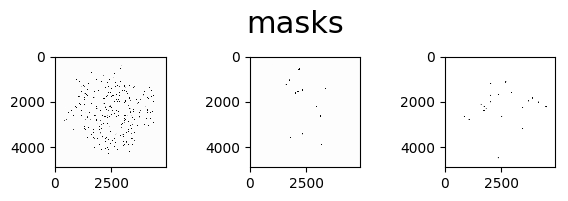

In [7]:
# Plot a batch.
ROWS, COLS = 1, 3
ROW_HEIGHT, COL_WIDTH = 2, 2

inputs, outputs = images_masks.get_batch(3)
visualization.show_image_grid(inputs, ROWS, COLS, ROW_HEIGHT*ROWS, COL_WIDTH*COLS, "images")
visualization.show_image_grid(outputs, ROWS, COLS, ROW_HEIGHT*ROWS, COL_WIDTH*COLS, "masks")

In [ ]:
# Normalize the images.
#def normalize(batch):
#    inputs, outputs = batch
#    inputs = preprocess.smdm_normalize(inputs, 61, "REFLECT")
#    return (inputs, outputs)
#images_masks.map_batch(normalize)

In [ ]:
# Plot a batch.
#inputs, outputs = images_masks.get_batch(3)
#visualization.show_image_grid(inputs, 1, 3, 2, 6, "images")
#visualization.show_image_grid(outputs, 1, 3, 2, 6, "masks")

In [8]:
# Extract patches from the images.
GRAY_MAX = 200
BLACK_MAX = 10
PATCH_SIZE = 61
MAX_PATCHES = 100_000
RGB_MAX = 255
SEGMENT_SIZE = 5000
CLASS_DIST = {0: 0.8, 1: 0.1, 2: 0.1}

def extract_patches(example):
    image, mask = example
    mask = np.mean(mask, axis=2)
    h, w = mask.shape
    mask_edge_or_inside = mask < GRAY_MAX
    mask_inside = mask < BLACK_MAX
    class_image = np.zeros_like(mask)
    class_image[mask_edge_or_inside] = 1
    class_image[mask_inside] = 2
    patches, classes = preprocess.extract_patches(image, class_image, PATCH_SIZE, max_patches=MAX_PATCHES, class_dist=CLASS_DIST)
    examples = [(patches[i, ...] / RGB_MAX, classes[i]) for i in range(classes.shape[0])]
    return examples

images_masks.map(extract_patches)
images_masks.set_segment_size(SEGMENT_SIZE)

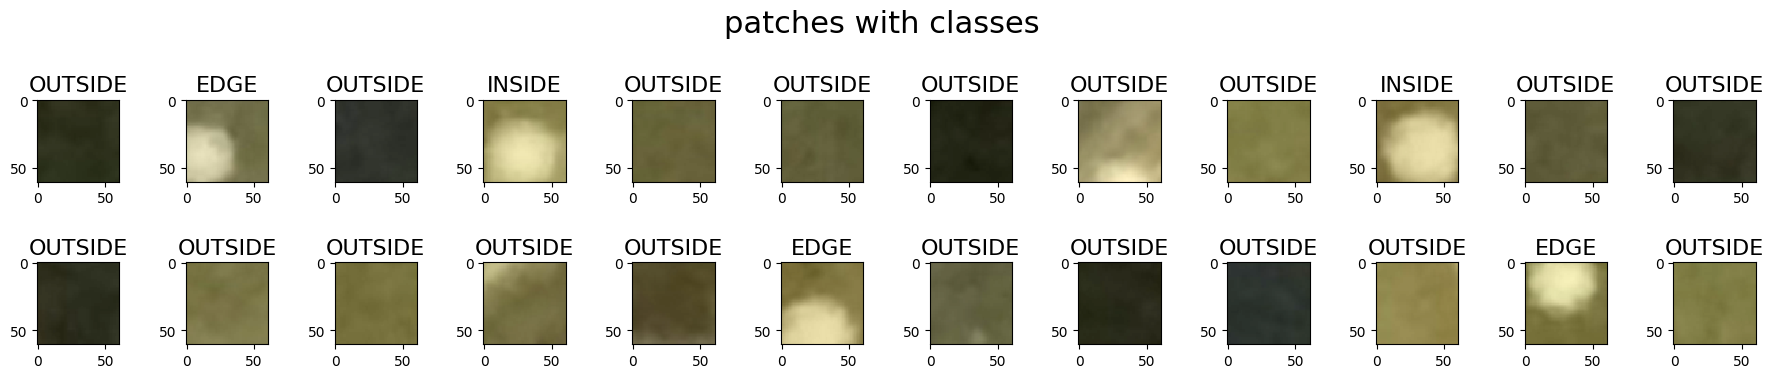

In [9]:
# Plot a batch.
CLASS_NAMES = {0:"OUTSIDE", 1:"EDGE", 2:"INSIDE"}
RGB_MAX = 255
GRID_ROWS, GRID_COLS = 2, 12
ROW_HEIGHT, COL_WIDTH = 2, 1.5

inputs, outputs = images_masks.get_batch(GRID_ROWS*GRID_COLS)
visualization.show_image_grid(inputs*RGB_MAX, GRID_ROWS, GRID_COLS, ROW_HEIGHT*GRID_ROWS, COL_WIDTH*GRID_COLS, "patches with classes",
                              [CLASS_NAMES[outputs[i]] for i in range(outputs.shape[0])])

In [10]:
# One-hot encode the labels.
import tensorflow as tf

def one_hot_encode(batch):
    inputs, outputs = batch
    with tf.Session().as_default():
        return inputs, tf.one_hot(tf.constant(outputs, dtype=tf.int32), 3).eval()
    
images_masks.map_batch(one_hot_encode)

In [11]:
# Split the dataset.
TEST_FRAC = 0.1

train, test = images_masks.split(TEST_FRAC, os.path.join(DATASETS_ROOT, "train"), os.path.join(DATASETS_ROOT, "test"))

## Load

**Instructions:** Run the cells in this section only if the dataset was previously preprocessed and saved.

In [ ]:
images_masks = dataset.Dataset(os.path.join(DATASETS_ROOT, "main"))
train, test = dataset.Dataset(os.path.join(DATASETS_ROOT, "train")), dataset.Dataset(os.path.join(DATASETS_ROOT, "test"))

# Model and Training

**INSTRUCTIONS:** Run the cells in this section.

In [12]:
# Create the net.
net = convnet3.ConvNet3(os.path.join(MODEL_SAVES_ROOT, MODEL_NAME), 120, train.size())

INFO:tensorflow:Using config: {'_model_dir': '/home/ubuntu/cell_counting/src/model/segmentation/convnet3/model_saves/dataset-100000-patches_training-45-on-p2xlarge_split-80-10-10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': None, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0b8c080358>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
# Create some metrics.
METRIC_BATCH_SIZE = 1000
NUM_CLASSES = 3

train_data = train.get_batch(METRIC_BATCH_SIZE)
test_data = test.get_batch(METRIC_BATCH_SIZE)

def loss_fn(predicted, actual):
    loss = tf.losses.softmax_cross_entropy(actual, predicted)
    with tf.Session().as_default():
        return loss.eval()

metrics = {
    "train_loss": metric.LossMetric(train_data, loss_fn),
    "test_loss": metric.LossMetric(test_data, loss_fn),
    "conf_mtx": metric.ConfusionMatrixMetric(test_data, NUM_CLASSES),
    "nx_conf_mtx": metric.NonexclusiveConfusionMatrixMetric(test_data, NUM_CLASSES)
}

In [14]:
# Make a function for plotting the metrics.
def plot_metrics():
    xs, ys = metrics["train_loss"].get_results()
    visualization.plot_line(xs, ys, "Training Loss", "training examples seen", "cross-entropy loss on training data", 3, 10)
    xs, ys = metrics["test_loss"].get_results()
    visualization.plot_line(xs, ys, "Test Loss", "training examples seen", "cross-entropy loss on test data", 3, 10)
    xs, ys = metrics["conf_mtx"].get_results()
    visualization.plot_confusion_matrix(ys[-1], "Test Confusion Matrix", 5, 5)
    xs, ys = metrics["nx_conf_mtx"].get_results()
    visualization.plot_confusion_matrix(ys[-1], "Nonexclusive Test Confusion Matrix", 5, 5)

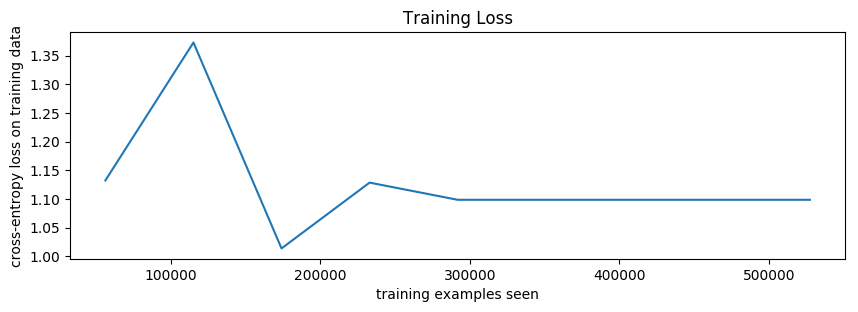

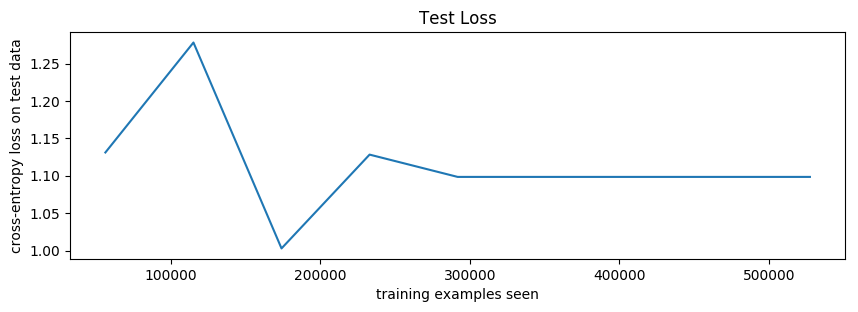

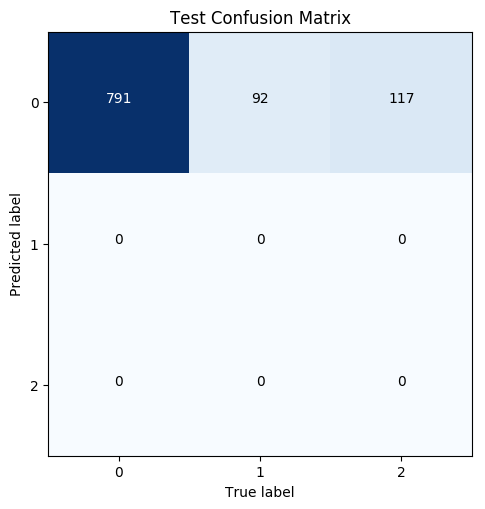

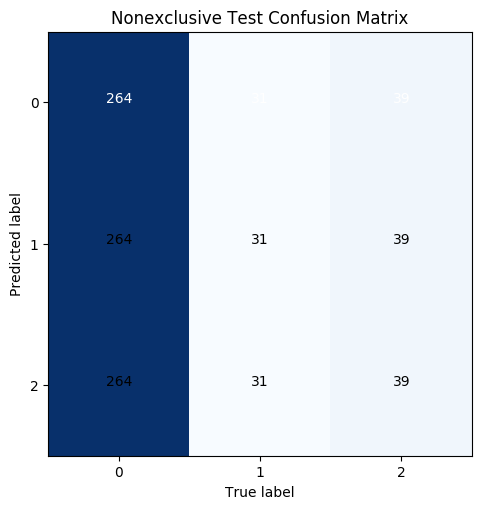

In [15]:
# Alternately train and evaluate the net for 20 minutes.
TRAIN_MINS = 45
REPORT_MINS = 5
SECS_PER_MIN = 60

for _ in range(TRAIN_MINS//REPORT_MINS):
    net.train(train, REPORT_MINS*SECS_PER_MIN)
    net.evaluate(metrics)
    display.clear_output()
    plot_metrics()